<a href="https://colab.research.google.com/github/juli-ter/Course3_work/blob/main/LDA%2BTone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 8.2 MB 10.4 MB/s 


In [4]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
import pymorphy2
import re
import string
from tqdm import tqdm
from collections import Counter
import numpy as np

from gensim import corpora
from datetime import datetime

tqdm.pandas()
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool
morph = pymorphy2.MorphAnalyzer()

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
%%capture
!pip install twarc #Twarc
!pip install tweepy # Tweepy 3.8.0
!pip install argparse #Argparse 3.2
!pip install xtract #Xtract 0.1 a3
!pip install wget #Wget 3.2


In [5]:
# import gzip
import shutil
import os
import wget
import csv
import linecache
# from shutil import copyfile
# import ipywidgets as widgets

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
path = "/content/drive/MyDrive/Course_3/"


### Словарь

In [10]:
from ast import literal_eval


In [11]:
ru = pd.read_csv('/content/drive/MyDrive/Course_3/clean_texts_ru.csv',  lineterminator='\n')
ru['text'] = ru['text'].apply(literal_eval)
ru

,text,date,raw_text,lang
0,"[помнить, ухань, мужчина, короновирус, масло, ...",Wed Apr 22 12:50:58 +0000 2020,А помните в Ухане мужчина с короновирусом в ра...,ru
1,"[выходить, выкинуть, мусор, сосед, напротив, в...",Wed Apr 15 18:30:08 +0000 2020,"выходила выкинуть мусор под домом, а дед-сосед...",ru
2,"[бесить, слово, коронавирус, появление, жизнь]",Tue May 05 09:08:05 +0000 2020,"Меня бесит слово ""коронавирус"" уже с самого ег...",ru
3,"[коммент, обсуждение, раскупать, магазин, врем...",Tue Mar 17 09:06:58 +0000 2020,топ коммент обсуждения что раскупают в магазин...,ru
4,"[действительно, делаться, очень, многое, прода...",Fri Mar 27 18:18:40 +0000 2020,"@dima_29ss @sd100674 Действительно, делается о...",ru
...,...,...,...,...
138960,"[грузия, рассчитывать, белорусский, турист, сп...",Thu May 21 09:21:21 +0000 2020,Грузия рассчитывает на белорусских туристов по...,ru
138961,"[никто, сломать, таджик, носитель, корона]",Sun Mar 08 08:00:31 +0000 2020,"@jksbabyboo Нас никогда никто не сломает, мы-т...",ru
138962,"[россия, нормально, долбоеб, принимать, решение]",Wed Apr 15 10:25:34 +0000 2020,"Так в России, это нормально, когда долбоебы пр...",ru
138963,"[коротко, ситуация, короновирус, город, массов...",Sun Mar 15 17:09:07 +0000 2020,Коротко о ситуации с короновирусом в моем горо...,ru


In [12]:
en = pd.read_csv('/content/drive/MyDrive/Course_3/clean_texts_en.csv',  lineterminator='\n')
en['text'] = en['text'].apply(literal_eval)
en

,text,date,raw_text
0,"[asks, life, back, normal, coronavirus]",Mon May 11 17:13:00 +0000 2020,umair haque asks if life will go back to norma...
1,"[cities, lockdown, amid, covid, scare, scenes,...",Mon Mar 23 08:49:20 +0000 2020,Cities under lockdown amid Covid-19 scare: Sce...
2,"[covid, conservative, need, self, test]",Mon May 25 18:05:05 +0000 2020,#SackBorisAndDom #COVID19 #Conservative #KierS...
3,"[governor, kemp, wont, open, georgia, restaura...",Fri Apr 24 17:21:24 +0000 2020,"No, Governor Kemp, I won’t open my Georgia res..."
4,"[wisconsin, coronavirus, cases, rise, nearly, ...",Sun May 31 00:17:34 +0000 2020,Wisconsin coronavirus cases rise by nearly 20 ...
...,...,...,...
128561,"[health, covid, enforcement, statistics, infor...",Fri Apr 17 14:50:26 +0000 2020,(Health) COVID-19 enforcement statistics infor...
128562,"[coronavirus, confirmed, cases, double, china,...",Tue Mar 31 16:37:19 +0000 2020,"""Coronavirus: US confirmed cases now double th..."
128563,"[aide, night, volunteer, lucky, worked]",Thu May 07 15:27:58 +0000 2020,Day Job: Cory Booker’s Top Aide. His Night One...
128564,"[remember, care, voters, care]",Sun Apr 12 23:42:11 +0000 2020,Remember: F*CK @speakvos @SenFitzgerald @mkego...


In [13]:
dictionary_ru = corpora.Dictionary(ru.text)
dictionary_en = corpora.Dictionary(en.text)

dictionary_ru.filter_extremes(no_below = 10, no_above = 0.65, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary_en.filter_extremes(no_below = 10, no_above = 0.65, keep_n=None)

dictionary_ru.save('lda_ru.dict')
dictionary_en.save('lda_en.dict')

In [14]:
corpus_ru = [dictionary_ru.doc2bow(text) for text in ru.text]
corpus_en = [dictionary_en.doc2bow(text) for text in en.text]

print(corpus_ru[:1])
# corpora.MmCorpus.serialize('lda_gensim.model', corpus_ru)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [13]:
%%capture

!pip install optuna


In [14]:
import optuna

###LDA

#### Английский

In [ ]:
def objective(trial):
    alpha = trial.suggest_uniform("alpha", 0.01, 1)
    eta = trial.suggest_uniform("eta", 0.01, 1)
    ntopics = trial.suggest_int("num_topics", 7, 35)

    model = LdaMulticore(
        workers=7,
        corpus=corpus_en,
        id2word=dictionary_en,
        num_topics=ntopics,
        random_state=10,
        passes=3,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
    )
    # coherence_score = compute_coherence(model, en.text, dictionary_en)
    sc = CoherenceModel(model, texts=en.text, dictionary=dictionary_en).get_coherence()
    print(f"Trial {trial.number} coherence score: {round(sc,3)}")
    return sc

In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial = study.best_trial

print('coherence: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-10-04 17:58:03,563] A new study created in memory with name: no-name-2fcffdf5-5ed5-4763-8c7c-b42b2181b2cd
[I 2021-10-04 17:58:47,251] Trial 0 finished with value: 0.3940287676891494 and parameters: {'alpha': 0.6008673179868854, 'eta': 0.4387406026766941, 'num_topics': 13}. Best is trial 0 with value: 0.3940287676891494.


Trial 0 coherence score: 0.394


[I 2021-10-04 17:59:32,034] Trial 1 finished with value: 0.34603317991395643 and parameters: {'alpha': 0.5053547409209893, 'eta': 0.7040500343164198, 'num_topics': 35}. Best is trial 0 with value: 0.3940287676891494.


Trial 1 coherence score: 0.346


[I 2021-10-04 18:00:15,550] Trial 2 finished with value: 0.3429654704589278 and parameters: {'alpha': 0.9069197514076242, 'eta': 0.23304134627619777, 'num_topics': 23}. Best is trial 0 with value: 0.3940287676891494.


Trial 2 coherence score: 0.343


[I 2021-10-04 18:00:59,213] Trial 3 finished with value: 0.40323886558918254 and parameters: {'alpha': 0.5394445357122674, 'eta': 0.9033197788767099, 'num_topics': 16}. Best is trial 3 with value: 0.40323886558918254.


Trial 3 coherence score: 0.403


[I 2021-10-04 18:01:43,995] Trial 4 finished with value: 0.3348210653523461 and parameters: {'alpha': 0.7526300865687281, 'eta': 0.6455293847801495, 'num_topics': 35}. Best is trial 3 with value: 0.40323886558918254.


Trial 4 coherence score: 0.335


[I 2021-10-04 18:02:28,438] Trial 5 finished with value: 0.3404733786658585 and parameters: {'alpha': 0.5262564148867741, 'eta': 0.7505516371060139, 'num_topics': 32}. Best is trial 3 with value: 0.40323886558918254.


Trial 5 coherence score: 0.34


[I 2021-10-04 18:03:20,078] Trial 6 finished with value: 0.3867802055413139 and parameters: {'alpha': 0.7653139789782512, 'eta': 0.017474032257838473, 'num_topics': 10}. Best is trial 3 with value: 0.40323886558918254.


Trial 6 coherence score: 0.387


[I 2021-10-04 18:04:07,522] Trial 7 finished with value: 0.36310629128057614 and parameters: {'alpha': 0.1798475524998558, 'eta': 0.15648396820098814, 'num_topics': 22}. Best is trial 3 with value: 0.40323886558918254.


Trial 7 coherence score: 0.363


[I 2021-10-04 18:04:51,230] Trial 8 finished with value: 0.33752884427762614 and parameters: {'alpha': 0.9535629754758479, 'eta': 0.21652857452282637, 'num_topics': 23}. Best is trial 3 with value: 0.40323886558918254.


Trial 8 coherence score: 0.338


[I 2021-10-04 18:05:35,494] Trial 9 finished with value: 0.3332591253007412 and parameters: {'alpha': 0.5727865136705769, 'eta': 0.8338849753164809, 'num_topics': 29}. Best is trial 3 with value: 0.40323886558918254.


Trial 9 coherence score: 0.333


[I 2021-10-04 18:06:19,913] Trial 10 finished with value: 0.366132383385948 and parameters: {'alpha': 0.24044560267556914, 'eta': 0.9729649011433602, 'num_topics': 15}. Best is trial 3 with value: 0.40323886558918254.


Trial 10 coherence score: 0.366


[I 2021-10-04 18:07:06,323] Trial 11 finished with value: 0.36143624556918036 and parameters: {'alpha': 0.33898921196057635, 'eta': 0.45876937465121853, 'num_topics': 14}. Best is trial 3 with value: 0.40323886558918254.


Trial 11 coherence score: 0.361


[I 2021-10-04 18:07:50,173] Trial 12 finished with value: 0.39537837599394976 and parameters: {'alpha': 0.6675894038548232, 'eta': 0.40694966080802625, 'num_topics': 7}. Best is trial 3 with value: 0.40323886558918254.


Trial 12 coherence score: 0.395


[I 2021-10-04 18:08:38,083] Trial 13 finished with value: 0.39210926097101406 and parameters: {'alpha': 0.3751293020584673, 'eta': 0.5438964104480344, 'num_topics': 8}. Best is trial 3 with value: 0.40323886558918254.


Trial 13 coherence score: 0.392


[I 2021-10-04 18:09:20,849] Trial 14 finished with value: 0.3444660110392359 and parameters: {'alpha': 0.6962460613861379, 'eta': 0.9961195631007114, 'num_topics': 18}. Best is trial 3 with value: 0.40323886558918254.


Trial 14 coherence score: 0.344


[I 2021-10-04 18:10:04,865] Trial 15 finished with value: 0.43922224810711136 and parameters: {'alpha': 0.0749542869548156, 'eta': 0.3823825510222242, 'num_topics': 7}. Best is trial 15 with value: 0.43922224810711136.


Trial 15 coherence score: 0.439


[I 2021-10-04 18:10:49,435] Trial 16 finished with value: 0.42003595783295 and parameters: {'alpha': 0.017556281345467176, 'eta': 0.29116056176922395, 'num_topics': 18}. Best is trial 15 with value: 0.43922224810711136.


Trial 16 coherence score: 0.42


[I 2021-10-04 18:11:36,759] Trial 17 finished with value: 0.41188842764194944 and parameters: {'alpha': 0.011516856321192318, 'eta': 0.3198523595128444, 'num_topics': 26}. Best is trial 15 with value: 0.43922224810711136.


Trial 17 coherence score: 0.412


[I 2021-10-04 18:12:19,413] Trial 18 finished with value: 0.4179973961185885 and parameters: {'alpha': 0.018295718600473045, 'eta': 0.5764720672192961, 'num_topics': 11}. Best is trial 15 with value: 0.43922224810711136.


Trial 18 coherence score: 0.418


[I 2021-10-04 18:13:07,610] Trial 19 finished with value: 0.3756292454188465 and parameters: {'alpha': 0.12408036028396739, 'eta': 0.07707955964634822, 'num_topics': 19}. Best is trial 15 with value: 0.43922224810711136.


Trial 19 coherence score: 0.376
Accuracy: 0.43922224810711136
Best hyperparameters: {'alpha': 0.0749542869548156, 'eta': 0.3823825510222242, 'num_topics': 7}


In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.005, 1)
    eta = trial.suggest_float("eta", 0.005, 1)
    ntopics = trial.suggest_int("num_topics", 7, 35)
    gamma  = trial.suggest_float("gamma", 0.001, 1)
    passes = trial.suggest_int("passes", 1, 7)
    model = LdaMulticore(
        workers=7,
        corpus=corpus_en,
        id2word=dictionary_en,
        num_topics=ntopics,
        random_state=42,
        passes=passes,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
        gamma_threshold = gamma,
    )
    # coherence_score = compute_coherence(model, en.text, dictionary_en)
    sc = CoherenceModel(model, texts=en.text, dictionary=dictionary_en).get_coherence()
    print(f"Trial {trial.number} coherence score: {round(sc,3)}")
    return sc

In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial_en = study.best_trial

print('coherence: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

[I 2021-10-05 18:50:44,556] A new study created in memory with name: no-name-37719465-1c78-4cd8-8c43-869d5a7ac479
[I 2021-10-05 18:51:46,680] Trial 0 finished with value: 0.07612080553732496 and parameters: {'alpha': 0.9909539929567402, 'eta': 0.35227922924099353, 'num_topics': 31, 'gamma': 0.611463580653266, 'passes': 5}. Best is trial 0 with value: 0.07612080553732496.


Trial 0 coherence score: 0.076


[I 2021-10-05 18:52:57,231] Trial 1 finished with value: 0.08257707025300923 and parameters: {'alpha': 0.6932948677413125, 'eta': 0.6374641513152941, 'num_topics': 34, 'gamma': 0.09110134210714724, 'passes': 5}. Best is trial 1 with value: 0.08257707025300923.


Trial 1 coherence score: 0.083


[I 2021-10-05 18:53:24,516] Trial 2 finished with value: 0.07389340157740894 and parameters: {'alpha': 0.5027275268010009, 'eta': 0.3812751169140533, 'num_topics': 27, 'gamma': 0.9305518795876913, 'passes': 2}. Best is trial 1 with value: 0.08257707025300923.


Trial 2 coherence score: 0.074


[I 2021-10-05 18:54:16,942] Trial 3 finished with value: 0.07431547467466688 and parameters: {'alpha': 0.770596322495563, 'eta': 0.4520510879967933, 'num_topics': 15, 'gamma': 0.8214774717530122, 'passes': 5}. Best is trial 1 with value: 0.08257707025300923.


Trial 3 coherence score: 0.074


[I 2021-10-05 18:55:10,500] Trial 4 finished with value: 0.07904209995772682 and parameters: {'alpha': 0.9968375417821395, 'eta': 0.5752811170348113, 'num_topics': 19, 'gamma': 0.28489124754655115, 'passes': 4}. Best is trial 1 with value: 0.08257707025300923.


Trial 4 coherence score: 0.079


[I 2021-10-05 18:55:26,850] Trial 5 finished with value: 0.06907817591980803 and parameters: {'alpha': 0.8454440155417761, 'eta': 0.1911196442125312, 'num_topics': 24, 'gamma': 0.25825271406572714, 'passes': 1}. Best is trial 1 with value: 0.08257707025300923.


Trial 5 coherence score: 0.069


[I 2021-10-05 18:57:32,463] Trial 6 finished with value: 0.24408483587335156 and parameters: {'alpha': 0.2740458395130144, 'eta': 0.6522902107467563, 'num_topics': 28, 'gamma': 0.09075691288146234, 'passes': 7}. Best is trial 6 with value: 0.24408483587335156.


Trial 6 coherence score: 0.244


[I 2021-10-05 18:59:12,285] Trial 7 finished with value: 0.23459709913683047 and parameters: {'alpha': 0.14853795202232953, 'eta': 0.8758615684924822, 'num_topics': 19, 'gamma': 0.18419253444220196, 'passes': 6}. Best is trial 6 with value: 0.24408483587335156.


Trial 7 coherence score: 0.235


[I 2021-10-05 18:59:41,519] Trial 8 finished with value: 0.08624641887765827 and parameters: {'alpha': 0.2961717449642569, 'eta': 0.13387273042543743, 'num_topics': 24, 'gamma': 0.41374361710050794, 'passes': 2}. Best is trial 6 with value: 0.24408483587335156.


Trial 8 coherence score: 0.086


[I 2021-10-05 19:00:04,839] Trial 9 finished with value: 0.07140577019611817 and parameters: {'alpha': 0.5681277485619023, 'eta': 0.503535290506378, 'num_topics': 11, 'gamma': 0.8154067161832325, 'passes': 2}. Best is trial 6 with value: 0.24408483587335156.


Trial 9 coherence score: 0.071


[I 2021-10-05 19:01:58,582] Trial 10 finished with value: 0.2617635738470866 and parameters: {'alpha': 0.06368591496375436, 'eta': 0.9841358668634405, 'num_topics': 30, 'gamma': 0.5644003424907015, 'passes': 7}. Best is trial 10 with value: 0.2617635738470866.


Trial 10 coherence score: 0.262


[I 2021-10-05 19:03:53,151] Trial 11 finished with value: 0.2691971390536196 and parameters: {'alpha': 0.015684519473475933, 'eta': 0.9991976620291241, 'num_topics': 30, 'gamma': 0.5996894864170613, 'passes': 7}. Best is trial 11 with value: 0.2691971390536196.


Trial 11 coherence score: 0.269


[I 2021-10-05 19:05:44,915] Trial 12 finished with value: 0.30537659356663654 and parameters: {'alpha': 0.06328447478692213, 'eta': 0.9900812747473176, 'num_topics': 35, 'gamma': 0.5882258793879109, 'passes': 7}. Best is trial 12 with value: 0.30537659356663654.


Trial 12 coherence score: 0.305


[I 2021-10-05 19:07:37,725] Trial 13 finished with value: 0.327277345650103 and parameters: {'alpha': 0.013659147003526821, 'eta': 0.7879281801724365, 'num_topics': 35, 'gamma': 0.6821308855454531, 'passes': 7}. Best is trial 13 with value: 0.327277345650103.


Trial 13 coherence score: 0.327


Process ForkPoolWorker-114:
Process ForkPoolWorker-115:
Process ForkPoolWorker-112:
Process ForkPoolWorker-110:
Traceback (most recent call last):
Process ForkPoolWorker-113:
Process ForkPoolWorker-109:
Process ForkPoolWorker-111:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/usr/local/lib/python3.7/dist-packages/gensim/models/ldamulticore

KeyboardInterrupt: ignored

In [ ]:
lda = LdaMulticore(workers=7,
        corpus=corpus_en,
        id2word=dictionary_en,
        num_topics=18,
        random_state=10,
        passes=6,
        alpha=0.3086397815311668,
        eta=0.8768887391044917,
        per_word_topics=True,
        gamma_threshold = 0.4511552336882485)

print('\nCoherence: ', CoherenceModel(model=lda, texts=en.text, dictionary=dictionary_en).get_coherence())
print('\nPerplexity: ', lda.log_perplexity(corpus_en))  # a measure of how good the model is. lower the better.


Coherence:  0.4964548356539531

Perplexity:  -4.259315243993335


#### Русский

In [ ]:
def objective_ru(trial):
    alpha = trial.suggest_float("alpha", 0.01, 1)
    eta = trial.suggest_float("eta", 0.01, 1)
    ntopics = trial.suggest_int("num_topics", 7, 35)

    model = LdaMulticore(
        workers=7,
        corpus=corpus_ru,
        id2word=dictionary_ru,
        num_topics=ntopics,
        random_state=10,
        passes=3,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
    )
    # coherence_score = compute_coherence(model, en.text, dictionary_en)
    sc = CoherenceModel(model, texts=ru.text, dictionary=dictionary_ru).get_coherence()
    print(f"Trial {trial.number} coherence score: {round(sc,3)}")
    return sc

In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective_ru, n_trials=20)
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-10-04 18:13:08,620] A new study created in memory with name: no-name-7ff88727-ee03-41e1-a7ee-69904f3fa7d8
[I 2021-10-04 18:14:39,141] Trial 0 finished with value: 0.19497832830307227 and parameters: {'alpha': 0.8267431877961886, 'eta': 0.08719811960573608, 'num_topics': 26}. Best is trial 0 with value: 0.19497832830307227.


Trial 0 coherence score: 0.195


[I 2021-10-04 18:17:44,353] Trial 1 finished with value: 0.3045693959233011 and parameters: {'alpha': 0.24533216078725684, 'eta': 0.2809848280954472, 'num_topics': 35}. Best is trial 1 with value: 0.3045693959233011.


Trial 1 coherence score: 0.305


[I 2021-10-04 18:21:27,499] Trial 2 finished with value: 0.3144925354237621 and parameters: {'alpha': 0.37624091918738567, 'eta': 0.2555815629264889, 'num_topics': 7}. Best is trial 2 with value: 0.3144925354237621.


Trial 2 coherence score: 0.314


[I 2021-10-04 18:24:14,145] Trial 3 finished with value: 0.33075684295068536 and parameters: {'alpha': 0.02204322295283015, 'eta': 0.05297326128480815, 'num_topics': 8}. Best is trial 3 with value: 0.33075684295068536.


Trial 3 coherence score: 0.331


[I 2021-10-04 18:27:01,874] Trial 4 finished with value: 0.2686620645109545 and parameters: {'alpha': 0.6383750799935446, 'eta': 0.8790059015784334, 'num_topics': 12}. Best is trial 3 with value: 0.33075684295068536.


Trial 4 coherence score: 0.269


[I 2021-10-04 18:30:00,066] Trial 5 finished with value: 0.32955756808365083 and parameters: {'alpha': 0.057339911436878784, 'eta': 0.9583090531649039, 'num_topics': 31}. Best is trial 3 with value: 0.33075684295068536.


Trial 5 coherence score: 0.33


[I 2021-10-04 18:31:24,696] Trial 6 finished with value: 0.19345381592524907 and parameters: {'alpha': 0.9012762490250726, 'eta': 0.9939729159986883, 'num_topics': 26}. Best is trial 3 with value: 0.33075684295068536.


Trial 6 coherence score: 0.193


[I 2021-10-04 18:34:23,090] Trial 7 finished with value: 0.32187935455815053 and parameters: {'alpha': 0.0907387556123991, 'eta': 0.5275446744800547, 'num_topics': 13}. Best is trial 3 with value: 0.33075684295068536.


Trial 7 coherence score: 0.322


[I 2021-10-04 18:37:29,973] Trial 8 finished with value: 0.28141934110971056 and parameters: {'alpha': 0.4277746963755045, 'eta': 0.2122545481935766, 'num_topics': 18}. Best is trial 3 with value: 0.33075684295068536.


Trial 8 coherence score: 0.281


[I 2021-10-04 18:38:54,180] Trial 9 finished with value: 0.19010891968738317 and parameters: {'alpha': 0.9560740111188007, 'eta': 0.45750278232329844, 'num_topics': 25}. Best is trial 3 with value: 0.33075684295068536.


Trial 9 coherence score: 0.19


[I 2021-10-04 18:41:55,776] Trial 10 finished with value: 0.27444489074608036 and parameters: {'alpha': 0.6086922794175514, 'eta': 0.01139283979916772, 'num_topics': 8}. Best is trial 3 with value: 0.33075684295068536.


Trial 10 coherence score: 0.274


[I 2021-10-04 18:44:40,340] Trial 11 finished with value: 0.3204015084764072 and parameters: {'alpha': 0.014426322811521026, 'eta': 0.7034254905143794, 'num_topics': 33}. Best is trial 3 with value: 0.33075684295068536.


Trial 11 coherence score: 0.32


[I 2021-10-04 18:47:44,148] Trial 12 finished with value: 0.2945674897165286 and parameters: {'alpha': 0.14825513329822104, 'eta': 0.6507731257027503, 'num_topics': 21}. Best is trial 3 with value: 0.33075684295068536.


Trial 12 coherence score: 0.295


[I 2021-10-04 18:51:01,880] Trial 13 finished with value: 0.3096153218480996 and parameters: {'alpha': 0.24091179674712926, 'eta': 0.8060098212008762, 'num_topics': 30}. Best is trial 3 with value: 0.33075684295068536.


Trial 13 coherence score: 0.31


[I 2021-10-04 18:53:54,311] Trial 14 finished with value: 0.3075952337586358 and parameters: {'alpha': 0.01251021897649418, 'eta': 0.43495494858906014, 'num_topics': 18}. Best is trial 3 with value: 0.33075684295068536.


Trial 14 coherence score: 0.308


[I 2021-10-04 18:57:11,459] Trial 15 finished with value: 0.30982227084715247 and parameters: {'alpha': 0.2734716323534021, 'eta': 0.5610792171186564, 'num_topics': 29}. Best is trial 3 with value: 0.33075684295068536.


Trial 15 coherence score: 0.31


[I 2021-10-04 19:00:19,197] Trial 16 finished with value: 0.31509958603086197 and parameters: {'alpha': 0.1580624215449088, 'eta': 0.37560531338045494, 'num_topics': 13}. Best is trial 3 with value: 0.33075684295068536.


Trial 16 coherence score: 0.315


[I 2021-10-04 19:03:07,227] Trial 17 finished with value: 0.26414689504532274 and parameters: {'alpha': 0.5252207896011214, 'eta': 0.9898711176432804, 'num_topics': 22}. Best is trial 3 with value: 0.33075684295068536.


Trial 17 coherence score: 0.264


[I 2021-10-04 19:06:37,769] Trial 18 finished with value: 0.2812532213444678 and parameters: {'alpha': 0.3419720165247623, 'eta': 0.15038050690990104, 'num_topics': 17}. Best is trial 3 with value: 0.33075684295068536.


Trial 18 coherence score: 0.281


[I 2021-10-04 19:08:09,335] Trial 19 finished with value: 0.1936240763190865 and parameters: {'alpha': 0.749360639795106, 'eta': 0.7823553594519681, 'num_topics': 30}. Best is trial 3 with value: 0.33075684295068536.


Trial 19 coherence score: 0.194
Accuracy: 0.33075684295068536
Best hyperparameters: {'alpha': 0.02204322295283015, 'eta': 0.05297326128480815, 'num_topics': 8}


In [ ]:
def objective_ru(trial):
    alpha = trial.suggest_uniform("alpha", 0.005, 1)
    eta = trial.suggest_uniform("eta", 0.005, 1)
    ntopics = trial.suggest_int("num_topics", 7, 35)
    # gamma  = trial.suggest_float("gamma", 0.001, 1)
    passes = trial.suggest_int("passes", 2, 7)

    model = LdaMulticore(
        workers=7,
        corpus=corpus_ru,
        id2word=dictionary_ru,
        num_topics=ntopics,
        random_state=10,
        passes=passes,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
        # gamma_threshold = gamma,
    )
    # coherence_score = compute_coherence(model, en.text, dictionary_en)
    sc = CoherenceModel(model, texts=ru.text, dictionary=dictionary_ru).get_coherence()
    print(f"Trial {trial.number} coherence score: {round(sc,3)}")
    return sc

In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective_ru, n_trials=20)
trial_ru = study.best_trial

print('Coherence: {}'.format(trial_ru.value))
print("Best hyperparameters: {}".format(trial_ru.params))

[I 2021-10-05 10:12:54,248] A new study created in memory with name: no-name-4f2d2495-57fd-41e0-85a7-f93d9b7c1df4
[I 2021-10-05 10:15:06,860] Trial 0 finished with value: 0.20709800497165148 and parameters: {'alpha': 0.6155695051899001, 'eta': 0.5335899034549616, 'num_topics': 31, 'passes': 4}. Best is trial 0 with value: 0.20709800497165148.


Trial 0 coherence score: 0.207


[I 2021-10-05 10:18:55,198] Trial 1 finished with value: 0.2650050460756473 and parameters: {'alpha': 0.7409116842841311, 'eta': 0.09063928358250557, 'num_topics': 22, 'passes': 7}. Best is trial 1 with value: 0.2650050460756473.


Trial 1 coherence score: 0.265


[I 2021-10-05 10:23:26,795] Trial 2 finished with value: 0.2899094319799216 and parameters: {'alpha': 0.7450196485940168, 'eta': 0.3948409974815212, 'num_topics': 12, 'passes': 7}. Best is trial 2 with value: 0.2899094319799216.


Trial 2 coherence score: 0.29


[I 2021-10-05 10:26:41,592] Trial 3 finished with value: 0.30046418159411015 and parameters: {'alpha': 0.2472331256610057, 'eta': 0.7921342216985994, 'num_topics': 14, 'passes': 3}. Best is trial 3 with value: 0.30046418159411015.


Trial 3 coherence score: 0.3


[I 2021-10-05 10:31:46,751] Trial 4 finished with value: 0.3282777261124296 and parameters: {'alpha': 0.026305342169059182, 'eta': 0.10125008061993918, 'num_topics': 9, 'passes': 7}. Best is trial 4 with value: 0.3282777261124296.


Trial 4 coherence score: 0.328


[I 2021-10-05 10:32:51,108] Trial 5 finished with value: 0.18994530119030648 and parameters: {'alpha': 0.6264346738419033, 'eta': 0.8337652583685625, 'num_topics': 30, 'passes': 2}. Best is trial 4 with value: 0.3282777261124296.


Trial 5 coherence score: 0.19


[I 2021-10-05 10:35:37,150] Trial 6 finished with value: 0.19917229438573766 and parameters: {'alpha': 0.8231663776554512, 'eta': 0.02988161188944163, 'num_topics': 34, 'passes': 6}. Best is trial 4 with value: 0.3282777261124296.


Trial 6 coherence score: 0.199


[I 2021-10-05 10:39:56,985] Trial 7 finished with value: 0.28763800742392637 and parameters: {'alpha': 0.4769112131424004, 'eta': 0.5010032728125915, 'num_topics': 28, 'passes': 6}. Best is trial 4 with value: 0.3282777261124296.


Trial 7 coherence score: 0.288


[I 2021-10-05 10:43:11,579] Trial 8 finished with value: 0.2764610205100192 and parameters: {'alpha': 0.32517163557781187, 'eta': 0.692745233081846, 'num_topics': 26, 'passes': 3}. Best is trial 4 with value: 0.3282777261124296.


Trial 8 coherence score: 0.276


[I 2021-10-05 10:45:14,167] Trial 9 finished with value: 0.27127293724961077 and parameters: {'alpha': 0.10554429268741297, 'eta': 0.29836468065491645, 'num_topics': 32, 'passes': 2}. Best is trial 4 with value: 0.3282777261124296.


Trial 9 coherence score: 0.271


[I 2021-10-05 10:48:57,129] Trial 10 finished with value: 0.3410898387898005 and parameters: {'alpha': 0.031233172628224275, 'eta': 0.22708982559920027, 'num_topics': 7, 'passes': 5}. Best is trial 10 with value: 0.3410898387898005.


Trial 10 coherence score: 0.341


[I 2021-10-05 10:52:43,954] Trial 11 finished with value: 0.34397715813499646 and parameters: {'alpha': 0.0522545905422338, 'eta': 0.2290330050624295, 'num_topics': 7, 'passes': 5}. Best is trial 11 with value: 0.34397715813499646.


Trial 11 coherence score: 0.344


[I 2021-10-05 10:57:01,539] Trial 12 finished with value: 0.3614761386567342 and parameters: {'alpha': 0.18796558253693615, 'eta': 0.21935448760549808, 'num_topics': 7, 'passes': 5}. Best is trial 12 with value: 0.3614761386567342.


Trial 12 coherence score: 0.361


[I 2021-10-05 11:01:55,415] Trial 13 finished with value: 0.3116653492720725 and parameters: {'alpha': 0.25687115304781377, 'eta': 0.24601515891110823, 'num_topics': 17, 'passes': 5}. Best is trial 12 with value: 0.3614761386567342.


Trial 13 coherence score: 0.312


[I 2021-10-05 11:05:56,326] Trial 14 finished with value: 0.3187035949758892 and parameters: {'alpha': 0.1918531459902478, 'eta': 0.9888383843228654, 'num_topics': 18, 'passes': 4}. Best is trial 12 with value: 0.3614761386567342.


Trial 14 coherence score: 0.319


[I 2021-10-05 11:10:38,919] Trial 15 finished with value: 0.3102683739290208 and parameters: {'alpha': 0.39029139351644854, 'eta': 0.4355240820790964, 'num_topics': 11, 'passes': 5}. Best is trial 12 with value: 0.3614761386567342.


Trial 15 coherence score: 0.31


[I 2021-10-05 11:15:27,021] Trial 16 finished with value: 0.36579439604758424 and parameters: {'alpha': 0.16720885843634734, 'eta': 0.17913792113661559, 'num_topics': 7, 'passes': 6}. Best is trial 16 with value: 0.36579439604758424.


Trial 16 coherence score: 0.366


[I 2021-10-05 11:18:27,723] Trial 17 finished with value: 0.2600956097806135 and parameters: {'alpha': 0.998358125976716, 'eta': 0.1608706085669962, 'num_topics': 15, 'passes': 6}. Best is trial 16 with value: 0.36579439604758424.


Trial 17 coherence score: 0.26


[I 2021-10-05 11:23:33,749] Trial 18 finished with value: 0.32151511964272894 and parameters: {'alpha': 0.16507564437178457, 'eta': 0.334353659511159, 'num_topics': 22, 'passes': 6}. Best is trial 16 with value: 0.36579439604758424.


Trial 18 coherence score: 0.322


[I 2021-10-05 11:27:22,841] Trial 19 finished with value: 0.3042249405960519 and parameters: {'alpha': 0.3979349016995969, 'eta': 0.008746771382740604, 'num_topics': 11, 'passes': 4}. Best is trial 16 with value: 0.36579439604758424.


Trial 19 coherence score: 0.304
Coherence: 0.36579439604758424
Best hyperparameters: {'alpha': 0.16720885843634734, 'eta': 0.17913792113661559, 'num_topics': 7, 'passes': 6}


In [ ]:
trial_ru.params

{'alpha': 0.16720885843634734,
 'eta': 0.17913792113661559,
 'num_topics': 7,
 'passes': 6}

In [ ]:
lda_ru = LdaMulticore(corpus=corpus_ru, id2word=dictionary_ru, num_topics=11, random_state=42)
coherence_model_lda = CoherenceModel(model=lda_ru, texts=ru.text, dictionary=dictionary_ru)
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.32984134042538105

In [ ]:
lda_ru = LdaMulticore(workers=7, corpus=corpus_ru, id2word=dictionary_ru, num_topics=7, passes=6, alpha=0.16720885843634734, random_state=10, eta=0.17913792113661559)
print('\nCoherence: ', CoherenceModel(model=lda_ru, texts=ru.text, dictionary=dictionary_ru).get_coherence())
print('\nPerplexity: ', lda_ru.log_perplexity(corpus_ru))  # a measure of how good the model is. lower the better.


Coherence:  0.37119581230779275

Perplexity:  -7.640731653109098


#### Mallet LDA

##### Mallet RUS

In [15]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [34]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'


In [35]:
import gensim

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_ru, workers=7, num_topics=8, id2word=dictionary_ru)
CoherenceModel(model=ldamallet, texts=ru.text, dictionary=dictionary_ru).get_coherence()

0.3929232759630886

In [ ]:
def objective_mallet(trial):
    alpha = trial.suggest_float("alpha", 0.005, 100)
    ntopics = trial.suggest_int("num_topics", 7, 35)
    iter = trial.suggest_int("iter", 100, 500)
    th = trial.suggest_float("th", 0, 50)
    model = gensim.models.wrappers.LdaMallet(mallet_path,
        workers=7,
        corpus=corpus_ru,
        id2word=dictionary_ru,
        num_topics=ntopics,
        alpha=alpha,
        iterations=iter,
        topic_threshold=th,
    )
    # coherence_score = compute_coherence(model, en.text, dictionary_en)
    sc = CoherenceModel(model, texts=ru.text, dictionary=dictionary_ru).get_coherence()
    print(f"Trial {trial.number} coherence score: {round(sc,3)}")
    return sc

In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective_mallet, n_trials=20)
trial_ru = study.best_trial

print('Coherence: {}'.format(trial_ru.value))
print("Best hyperparameters: {}".format(trial_ru.params))

[I 2021-10-05 15:29:42,843] A new study created in memory with name: no-name-7b66a8ca-1c29-4d8c-b18d-2dae1bc386ca
[I 2021-10-05 15:31:13,608] Trial 0 finished with value: 0.2901950958935901 and parameters: {'alpha': 96.56545375608016, 'num_topics': 23, 'iter': 213, 'th': 46.206803456455376}. Best is trial 0 with value: 0.2901950958935901.


Trial 0 coherence score: 0.29


[I 2021-10-05 15:32:21,473] Trial 1 finished with value: 0.29446923570449435 and parameters: {'alpha': 57.16962566010215, 'num_topics': 20, 'iter': 130, 'th': 47.92900673548908}. Best is trial 1 with value: 0.29446923570449435.


Trial 1 coherence score: 0.294


[I 2021-10-05 15:33:22,663] Trial 2 finished with value: 0.37779419943280085 and parameters: {'alpha': 1.7911280675560046, 'num_topics': 14, 'iter': 135, 'th': 4.66293108013926}. Best is trial 2 with value: 0.37779419943280085.


Trial 2 coherence score: 0.378


[I 2021-10-05 15:35:34,474] Trial 3 finished with value: 0.3141057718503182 and parameters: {'alpha': 63.17441289663557, 'num_topics': 30, 'iter': 385, 'th': 22.47706587119691}. Best is trial 2 with value: 0.37779419943280085.


Trial 3 coherence score: 0.314


[I 2021-10-05 15:37:46,606] Trial 4 finished with value: 0.3606144908101874 and parameters: {'alpha': 31.070800031960523, 'num_topics': 32, 'iter': 399, 'th': 11.623765111236212}. Best is trial 2 with value: 0.37779419943280085.


Trial 4 coherence score: 0.361


[I 2021-10-05 15:39:16,592] Trial 5 finished with value: 0.36765492651424997 and parameters: {'alpha': 28.705203425347644, 'num_topics': 28, 'iter': 212, 'th': 22.65768521065682}. Best is trial 2 with value: 0.37779419943280085.


Trial 5 coherence score: 0.368


[I 2021-10-05 15:40:38,812] Trial 6 finished with value: 0.4202408455880105 and parameters: {'alpha': 6.222443606275627, 'num_topics': 18, 'iter': 226, 'th': 12.62577246973325}. Best is trial 6 with value: 0.4202408455880105.


Trial 6 coherence score: 0.42


[I 2021-10-05 15:41:46,890] Trial 7 finished with value: 0.3976028092665057 and parameters: {'alpha': 20.607593955175297, 'num_topics': 21, 'iter': 140, 'th': 15.684538584367457}. Best is trial 6 with value: 0.4202408455880105.


Trial 7 coherence score: 0.398


KeyboardInterrupt: ignored

In [36]:
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_ru, workers=7, num_topics=18, id2word=dictionary_ru, alpha=6.22, iterations=226, topic_threshold=13)
print('\nCoherence: ', CoherenceModel(model=lda_mallet, texts=ru.text, dictionary=dictionary_ru).get_coherence())
# print('\nPerplexity: ', lda_mallet.log_perplexity(corpus_ru))  # a measure of how good the model is. lower the better.


Coherence:  0.401988090499531


In [42]:
topics = [[(term, round(wt, 3)) for term, wt in lda_mallet.show_topic(n, topn=20)] for n in range(0, lda_mallet.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, lda_mallet.num_topics+1)])
# pd.set_option('display.max_colwidth', -1)
topics_df

,Term1,Term2,Term3,Term4,Term5,Term6,Term7,Term8,Term9,Term10,Term11,Term12,Term13,Term14,Term15,Term16,Term17,Term18,Term19,Term20
Topic 1,вирус,корона,человек,очень,говорить,просто,знать,большой,вообще,никто,болеть,бояться,сказать,думать,понимать,пока,вроде,умереть,паника,ситуация
Topic 2,вирус,человек,корона,думать,хороший,сказать,остаться,знать,жизнь,пусть,жить,просто,сторона,вообще,мозг,говорить,бояться,проблема,хотеть,воздух
Topic 3,маска,сегодня,магазин,вчера,ребёнок,сказать,мама,человек,ходить,выйти,купить,улица,работа,продукт,работать,покупать,видеть,собака,пойти,бумага
Topic 4,карантин,день,неделя,идти,месяц,второй,каждый,самоизоляция,конец,первый,продлить,сегодня,утро,апрель,назад,начало,третий,пара,сидеть,следующий
Topic 5,человек,карантин,улица,самоизоляция,сидеть,выходить,город,место,соблюдать,ходить,рука,работа,гулять,время,выйти,работать,никто,оставаться,вообще,народ
Topic 6,карантин,время,смотреть,самый,жизнь,хороший,посмотреть,очень,самоизоляция,фильм,читать,стать,сериал,заниматься,интересный,книга,спасибо,начало,игра,плюс
Topic 7,статистика,человек,смертность,пневмония,большой,коронавирус,грипп,орви,заболеть,умереть,больной,умирать,лёгкий,врач,смерть,уровень,больница,сколько,высокий,корона
Topic 8,пандемия,борьба,мера,коронавирус,covid,помощь,распространение,период,работа,бизнес,условие,инфекция,профилактика,деньга,правительство,коронавирусный,связь,эпидемия,государство,поддержка
Topic 9,covid,коронавирус,пандемия,человек,вирус,против,далее,отменить,группа,провести,первый,ковид,дело,отметить,эпидемия,канал,делать,онлайн,coronavirus,внимание
Topic 10,коронавирус,россия,covid,пандемия,путин,эпидемия,ситуация,президент,заявить,страна,глава,москва,трамп,распространение,связь,украина,назвать,рассказать,минздрав,борьба


In [43]:
topics_df.to_csv(path+'topcs_ru.csv')

In [ ]:
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_mallet.num_topics+1)] )

In [20]:
from wordcloud import WordCloud


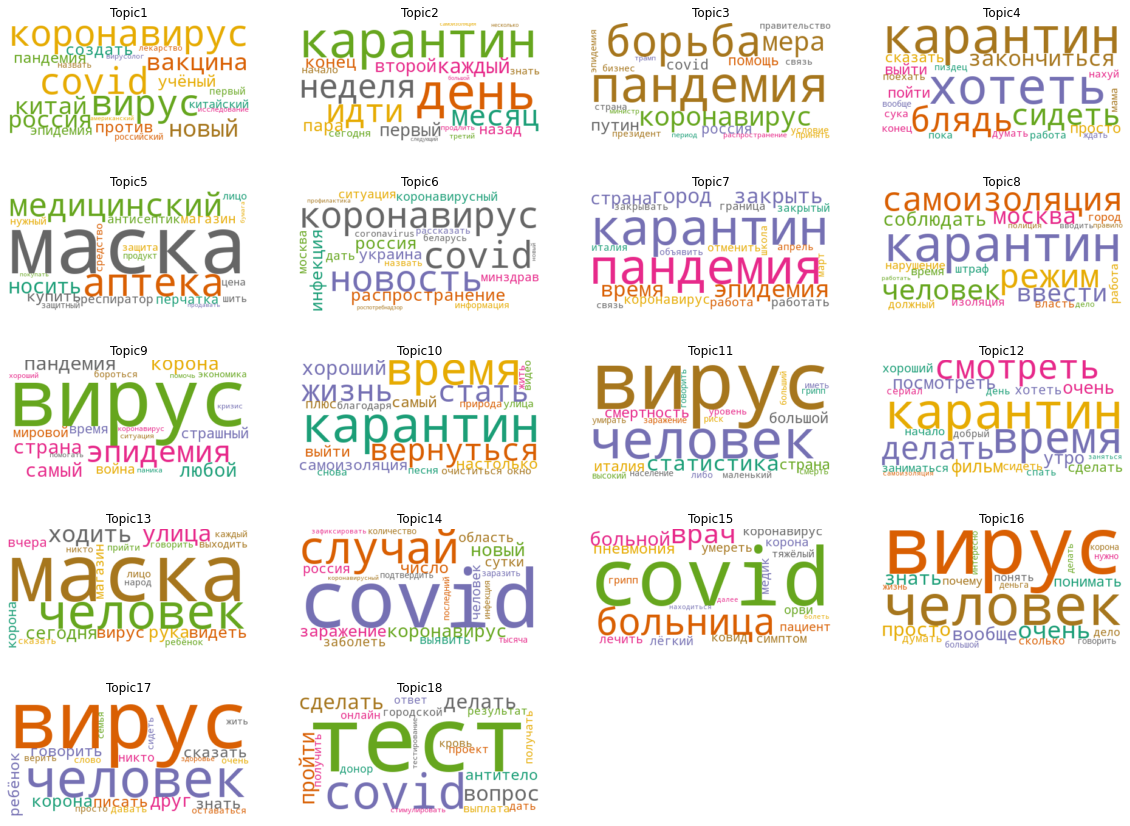

In [24]:

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42, max_words=30)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(lda_mallet.num_topics):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

##### Mallet ENG

In [25]:
lda_mallet_en = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_en, workers=7, num_topics=13, id2word=dictionary_en)
print('\nCoherence: ', CoherenceModel(model=lda_mallet_en, texts=en.text, dictionary=dictionary_en).get_coherence())


Coherence:  0.27612726454822306


In [ ]:
def objective_mallet_en(trial):
    alpha = trial.suggest_float("alpha", 0.005, 100)
    ntopics = trial.suggest_int("num_topics", 7, 30)
    iter = trial.suggest_int("iter", 100, 700)
    # th = trial.suggest_float("th", 0, 60)
    model = gensim.models.wrappers.LdaMallet(mallet_path,
        workers=7,
        corpus=corpus_en,
        id2word=dictionary_en,
        num_topics=ntopics,
        alpha=alpha,
        iterations=iter,
        # topic_threshold=th,
    )
    # coherence_score = compute_coherence(model, en.text, dictionary_en)
    sc = CoherenceModel(model, texts=en.text, dictionary=dictionary_en).get_coherence()
    print(f"Trial {trial.number} coherence score: {round(sc,3)}")
    return sc

study = optuna.create_study(direction='maximize')
study.optimize(objective_mallet_en, n_trials=20)
trial_en = study.best_trial

print('Coherence: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

[I 2021-10-05 19:46:52,190] A new study created in memory with name: no-name-a98c208e-c7be-41c9-b5a7-dc7c42095b09
[I 2021-10-05 19:47:54,881] Trial 0 finished with value: 0.21143487249424045 and parameters: {'alpha': 34.39939613380515, 'num_topics': 7, 'iter': 202}. Best is trial 0 with value: 0.21143487249424045.


Trial 0 coherence score: 0.211


[I 2021-10-05 19:50:01,797] Trial 1 finished with value: 0.2436939216676004 and parameters: {'alpha': 71.18176764696952, 'num_topics': 10, 'iter': 587}. Best is trial 1 with value: 0.2436939216676004.


Trial 1 coherence score: 0.244


[I 2021-10-05 19:51:01,777] Trial 2 finished with value: 0.18263213156682073 and parameters: {'alpha': 70.20223027388023, 'num_topics': 11, 'iter': 155}. Best is trial 1 with value: 0.2436939216676004.


Trial 2 coherence score: 0.183


[I 2021-10-05 19:53:04,924] Trial 3 finished with value: 0.33468404798534584 and parameters: {'alpha': 5.998034985849953, 'num_topics': 22, 'iter': 485}. Best is trial 3 with value: 0.33468404798534584.


Trial 3 coherence score: 0.335


[I 2021-10-05 19:54:39,273] Trial 4 finished with value: 0.23520139284163727 and parameters: {'alpha': 70.1332444914638, 'num_topics': 15, 'iter': 328}. Best is trial 3 with value: 0.33468404798534584.


Trial 4 coherence score: 0.235


[I 2021-10-05 19:56:27,023] Trial 5 finished with value: 0.24602461108750662 and parameters: {'alpha': 92.65519145330634, 'num_topics': 26, 'iter': 357}. Best is trial 3 with value: 0.33468404798534584.


Trial 5 coherence score: 0.246


[I 2021-10-05 19:58:30,014] Trial 6 finished with value: 0.28645265490823657 and parameters: {'alpha': 34.065368802657716, 'num_topics': 9, 'iter': 604}. Best is trial 3 with value: 0.33468404798534584.


Trial 6 coherence score: 0.286


[I 2021-10-05 20:00:49,473] Trial 7 finished with value: 0.2586781512290156 and parameters: {'alpha': 73.09306931523268, 'num_topics': 21, 'iter': 559}. Best is trial 3 with value: 0.33468404798534584.


Trial 7 coherence score: 0.259


[I 2021-10-05 20:02:34,117] Trial 8 finished with value: 0.2891951425496742 and parameters: {'alpha': 46.16204274088623, 'num_topics': 19, 'iter': 381}. Best is trial 3 with value: 0.33468404798534584.


Trial 8 coherence score: 0.289


[I 2021-10-05 20:04:48,584] Trial 9 finished with value: 0.29252649802612385 and parameters: {'alpha': 34.874376130726105, 'num_topics': 14, 'iter': 583}. Best is trial 3 with value: 0.33468404798534584.


Trial 9 coherence score: 0.293


[I 2021-10-05 20:07:03,856] Trial 10 finished with value: 0.3262733073064953 and parameters: {'alpha': 0.43227870401219715, 'num_topics': 30, 'iter': 459}. Best is trial 3 with value: 0.33468404798534584.


Trial 10 coherence score: 0.326


[I 2021-10-05 20:09:16,720] Trial 11 finished with value: 0.3162603701488763 and parameters: {'alpha': 12.025121792686317, 'num_topics': 30, 'iter': 477}. Best is trial 3 with value: 0.33468404798534584.


Trial 11 coherence score: 0.316


[I 2021-10-05 20:11:18,285] Trial 12 finished with value: 0.3582507272391072 and parameters: {'alpha': 4.848826904621204, 'num_topics': 25, 'iter': 452}. Best is trial 12 with value: 0.3582507272391072.


Trial 12 coherence score: 0.358


[I 2021-10-05 20:12:43,178] Trial 13 finished with value: 0.3041741415356327 and parameters: {'alpha': 14.163066835651904, 'num_topics': 23, 'iter': 268}. Best is trial 12 with value: 0.3582507272391072.


Trial 13 coherence score: 0.304


[I 2021-10-05 20:15:29,752] Trial 14 finished with value: 0.3651988572950391 and parameters: {'alpha': 2.871640158872077, 'num_topics': 25, 'iter': 675}. Best is trial 14 with value: 0.3651988572950391.


Trial 14 coherence score: 0.365


[I 2021-10-05 20:18:16,793] Trial 15 finished with value: 0.31245537968794707 and parameters: {'alpha': 22.4726061591212, 'num_topics': 26, 'iter': 674}. Best is trial 14 with value: 0.3651988572950391.


Trial 15 coherence score: 0.312


[I 2021-10-05 20:20:58,161] Trial 16 finished with value: 0.3139884794328681 and parameters: {'alpha': 21.552588007054997, 'num_topics': 26, 'iter': 647}. Best is trial 14 with value: 0.3651988572950391.


Trial 16 coherence score: 0.314


[I 2021-10-05 20:22:28,483] Trial 17 finished with value: 0.26328513767201134 and parameters: {'alpha': 50.83872523135421, 'num_topics': 24, 'iter': 272}. Best is trial 14 with value: 0.3651988572950391.


Trial 17 coherence score: 0.263


[I 2021-10-05 20:24:37,290] Trial 18 finished with value: 0.3433393550997667 and parameters: {'alpha': 1.1553580131989294, 'num_topics': 17, 'iter': 526}. Best is trial 14 with value: 0.3651988572950391.


Trial 18 coherence score: 0.343


[I 2021-10-05 20:27:30,339] Trial 19 finished with value: 0.3097328549505603 and parameters: {'alpha': 18.19962344074123, 'num_topics': 28, 'iter': 697}. Best is trial 14 with value: 0.3651988572950391.


Trial 19 coherence score: 0.31
Coherence: 0.3651988572950391
Best hyperparameters: {'alpha': 2.871640158872077, 'num_topics': 25, 'iter': 675}


In [39]:
lda_mallet_en = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_en, workers=7, num_topics=17, id2word=dictionary_en, alpha=1.1553580131989294, iterations=526)
print('\nCoherence: ', CoherenceModel(model=lda_mallet_en, texts=en.text, dictionary=dictionary_en).get_coherence())


Coherence:  0.3137747716784592


In [41]:
topics = [[(term, round(wt, 3)) for term, wt in lda_mallet_en.show_topic(n, topn=20)] for n in range(0, lda_mallet_en.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, lda_mallet_en.num_topics+1)])
topics_df.to_csv(path+'topcs_en.csv')

In [ ]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_mallet_en.num_topics+1)] )

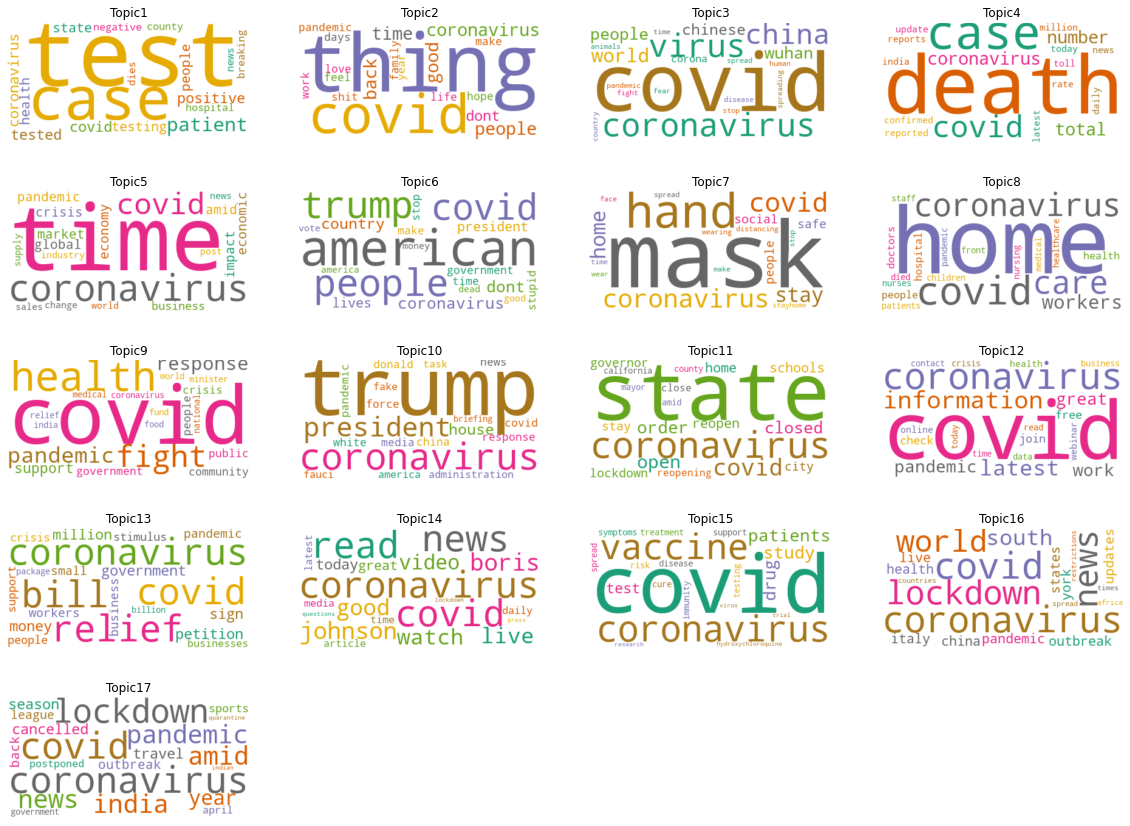

In [29]:

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42, max_words = 30)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(lda_mallet_en.num_topics):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [30]:

from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim


In [31]:
ldagensim = convertldaMalletToldaGen(lda_mallet) 
# print('\nPerplexity: ', ldagensim.log_perplexity(corpus_ru))  # a measure of how good the model is. lower the better.

In [32]:
ldagensim_en = convertldaMalletToldaGen(lda_mallet_en)
# print('\nPerplexity: ', ldagensim_en.log_perplexity(corpus_en))  # a measure of how good the model is. lower the better.

In [ ]:
ldagensim.save(path+'LDA/ldagensim.model')
ldagensim_en.save(path+'LDA/ldagensim_en.model')

#### Визуализация

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models  as gensimvis
import pyLDAvis

In [8]:
lda_en = LdaMulticore.load(path+'LDA/ldagensim_en.model')
lda_ru = LdaMulticore.load(path+'LDA/ldagensim.model')


In [15]:

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_ru, corpus_ru, dictionary_ru)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.275561  0.020779       1        1  6.502201
2     -0.236369  0.106026       2        1  5.882018
3      0.260032  0.103801       3        1  5.824987
4      0.029825 -0.107114       4        1  5.809973
15     0.172867 -0.197614       5        1  5.742995
11     0.239655  0.132286       6        1  5.594710
12     0.146627 -0.198577       7        1  5.549459
5     -0.311687  0.076940       8        1  5.544361
1      0.189604  0.200630       9        1  5.507403
8     -0.051734 -0.130652      10        1  5.501426
10    -0.032047 -0.241297      11        1  5.470321
16     0.147726 -0.214396      12        1  5.455401
9      0.206557  0.137916      13        1  5.340326
6     -0.029818  0.184001      14        1  5.337723
0     -0.240641 -0.001747      15        1  5.329057
7      0.066244  0.138336      16        1  5.304585
14    -0.213426 -0.058173      17        1  5.220952
17    -0.067856  0.048856      18        1  5.082102, topic_info=             Term          Freq         Total Category  logprob  loglift
24       карантин  33838.000000  33838.000000  Default  30.0000  30.0000
31          маска  16318.000000  16318.000000  Default  29.0000  29.0000
81          covid  18643.000000  18643.000000  Default  28.0000  28.0000
20    коронавирус  17169.000000  17169.000000  Default  27.0000  27.0000
43           день   6757.000000   6757.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
830        делать    701.549804   2911.362629  Topic18  -4.3093   1.5564
541          дать    520.383865   1695.467807  Topic18  -4.6080   1.7983
2221     провести    356.070582    744.657120  Topic18  -4.9875   2.2417
1148      система    298.139630    522.451750  Topic18  -5.1650   2.4185
175         нужно    338.164657   1617.982340  Topic18  -5.0391   1.4140

[1222 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
253       1  0.118212  coronavirus
253       4  0.001665  coronavirus
253       8  0.837474  coronavirus
253      13  0.001665  coronavirus
253      17  0.039959  coronavirus
...     ...       ...          ...
111       8  0.861933        южный
766      10  0.981417      ядерный
2768     13  0.989099         яйцо
2444      3  0.995144       ёбаный
2444     10  0.003110       ёбаный

[2396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 3, 4, 5, 16, 12, 13, 6, 2, 9, 11, 17, 10, 7, 1, 8, 15, 18])

In [16]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_en, corpus_en, dictionary_en)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.231557  0.000848       1        1  7.003895
3      0.226489  0.144942       2        1  6.701908
5     -0.263427  0.114080       3        1  6.545691
11    -0.004332 -0.222540       4        1  6.209564
8      0.051997 -0.198515       5        1  6.044678
9     -0.073343  0.176166       6        1  5.982244
13    -0.119924  0.006932       7        1  5.938692
4      0.055431 -0.087715       8        1  5.899204
2     -0.115364  0.103136       9        1  5.765165
7     -0.004947 -0.051472      10        1  5.693268
14     0.038588  0.071187      11        1  5.659607
6     -0.117359 -0.089699      12        1  5.646416
15     0.130416  0.134661      13        1  5.586440
10     0.132411 -0.042956      14        1  5.515708
12     0.024343 -0.135398      15        1  5.369924
16     0.085425 -0.010518      16        1  5.298590
0      0.185153  0.086861      17        1  5.139006, topic_info=             Term          Freq         Total Category  logprob  loglift
24          cases   6729.000000   6729.000000  Default  30.0000  30.0000
151         trump   6539.000000   6539.000000  Default  29.0000  29.0000
2     coronavirus  48310.000000  48310.000000  Default  28.0000  28.0000
58         deaths   3497.000000   3497.000000  Default  27.0000  27.0000
60       positive   2575.000000   2575.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1103     infected    212.414241    752.408817  Topic17  -5.4514   1.7036
301    quarantine    232.321981   1138.696072  Topic17  -5.3618   1.3788
91           news    362.828270   5057.152953  Topic17  -4.9160   0.3337
64          today    230.110008   2513.600166  Topic17  -5.3714   0.5774
172          days    199.142422   1380.530603  Topic17  -5.5159   1.0321

[1299 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4640      9  0.988349  aarogya
7811     17  0.970328     abba
6801     17  0.946201   aboard
3898     13  0.151890   abroad
3898     16  0.835398   abroad
...     ...       ...      ...
319      12  0.093154    youre
319      13  0.010959    youre
838       6  0.147376  youtube
838       7  0.846360  youtube
6525      1  0.963338   zombie

[3255 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 12, 9, 10, 14, 5, 3, 8, 15, 7, 16, 11, 13, 17, 1])

## Tone

#### dostoevsky

In [ ]:
ru

,text,date,raw_text,lang
0,"[помнить, ухань, мужчина, короновирус, масло, ...",Wed Apr 22 12:50:58 +0000 2020,А помните в Ухане мужчина с короновирусом в ра...,ru
1,"[выходить, выкинуть, мусор, сосед, напротив, в...",Wed Apr 15 18:30:08 +0000 2020,"выходила выкинуть мусор под домом, а дед-сосед...",ru
2,"[бесить, слово, коронавирус, появление, жизнь]",Tue May 05 09:08:05 +0000 2020,"Меня бесит слово ""коронавирус"" уже с самого ег...",ru
3,"[коммент, обсуждение, раскупать, магазин, врем...",Tue Mar 17 09:06:58 +0000 2020,топ коммент обсуждения что раскупают в магазин...,ru
4,"[действительно, делаться, очень, многое, прода...",Fri Mar 27 18:18:40 +0000 2020,"@dima_29ss @sd100674 Действительно, делается о...",ru
...,...,...,...,...
138960,"[грузия, рассчитывать, белорусский, турист, сп...",Thu May 21 09:21:21 +0000 2020,Грузия рассчитывает на белорусских туристов по...,ru
138961,"[никто, сломать, таджик, носитель, корона]",Sun Mar 08 08:00:31 +0000 2020,"@jksbabyboo Нас никогда никто не сломает, мы-т...",ru
138962,"[россия, нормально, долбоеб, принимать, решение]",Wed Apr 15 10:25:34 +0000 2020,"Так в России, это нормально, когда долбоебы пр...",ru
138963,"[коротко, ситуация, короновирус, город, массов...",Sun Mar 15 17:09:07 +0000 2020,Коротко о ситуации с короновирусом в моем горо...,ru


In [ ]:
!pip install dostoevsky

     |████████████████████████████████| 68 kB 3.4 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3124764 sha256=7c12e56c9e6ac54fdb43baa003b23daa5ededb2044b32a53bb9db5eb015f3fa3
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [ ]:
!python -m dostoevsky download fasttext-social-network-model


In [ ]:


tokenizer = RegexTokenizer()
tokens = tokenizer.split('всё очень плохо')  # [('всё', None), ('очень', None), ('плохо', None)]

model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [ ]:
# ru['text_str'] = ru.text.apply(lambda x: ' '.join(x))
messages = ru.text_str.to_list()
ru['tones'] = model.predict(messages, k=10)
ru

,text,date,raw_text,lang,text_str,tones
0,"[помнить, ухань, мужчина, короновирус, масло, ...",Wed Apr 22 12:50:58 +0000 2020,А помните в Ухане мужчина с короновирусом в ра...,ru,помнить ухань мужчина короновирус масло упасть...,"{'skip': 0.40734341740608215, 'neutral': 0.250..."
1,"[выходить, выкинуть, мусор, сосед, напротив, в...",Wed Apr 15 18:30:08 +0000 2020,"выходила выкинуть мусор под домом, а дед-сосед...",ru,выходить выкинуть мусор сосед напротив выйти к...,"{'skip': 0.6926519870758057, 'negative': 0.294..."
2,"[бесить, слово, коронавирус, появление, жизнь]",Tue May 05 09:08:05 +0000 2020,"Меня бесит слово ""коронавирус"" уже с самого ег...",ru,бесить слово коронавирус появление жизнь,"{'negative': 0.8354935646057129, 'positive': 0..."
3,"[коммент, обсуждение, раскупать, магазин, врем...",Tue Mar 17 09:06:58 +0000 2020,топ коммент обсуждения что раскупают в магазин...,ru,коммент обсуждение раскупать магазин время кар...,"{'neutral': 0.7663036584854126, 'negative': 0...."
4,"[действительно, делаться, очень, многое, прода...",Fri Mar 27 18:18:40 +0000 2020,"@dima_29ss @sd100674 Действительно, делается о...",ru,действительно делаться очень многое продать ма...,"{'neutral': 0.9304682612419128, 'negative': 0...."
...,...,...,...,...,...,...
138960,"[грузия, рассчитывать, белорусский, турист, сп...",Thu May 21 09:21:21 +0000 2020,Грузия рассчитывает на белорусских туристов по...,ru,грузия рассчитывать белорусский турист спад эп...,"{'neutral': 0.9740526676177979, 'negative': 0...."
138961,"[никто, сломать, таджик, носитель, корона]",Sun Mar 08 08:00:31 +0000 2020,"@jksbabyboo Нас никогда никто не сломает, мы-т...",ru,никто сломать таджик носитель корона,"{'neutral': 0.880807101726532, 'negative': 0.2..."
138962,"[россия, нормально, долбоеб, принимать, решение]",Wed Apr 15 10:25:34 +0000 2020,"Так в России, это нормально, когда долбоебы пр...",ru,россия нормально долбоеб принимать решение,"{'neutral': 0.5544804334640503, 'negative': 0...."
138963,"[коротко, ситуация, короновирус, город, массов...",Sun Mar 15 17:09:07 +0000 2020,Коротко о ситуации с короновирусом в моем горо...,ru,коротко ситуация короновирус город массово ску...,"{'neutral': 0.7186043858528137, 'negative': 0...."


In [ ]:
ru['tones'] = model.predict(messages, k=-1)
ru

,text,date,raw_text,lang,text_str,tones
0,"[помнить, ухань, мужчина, короновирус, масло, ...",Wed Apr 22 12:50:58 +0000 2020,А помните в Ухане мужчина с короновирусом в ра...,ru,помнить ухань мужчина короновирус масло упасть...,"{'skip': 0.40734341740608215, 'neutral': 0.250..."
1,"[выходить, выкинуть, мусор, сосед, напротив, в...",Wed Apr 15 18:30:08 +0000 2020,"выходила выкинуть мусор под домом, а дед-сосед...",ru,выходить выкинуть мусор сосед напротив выйти к...,"{'skip': 0.6926519870758057, 'negative': 0.294..."
2,"[бесить, слово, коронавирус, появление, жизнь]",Tue May 05 09:08:05 +0000 2020,"Меня бесит слово ""коронавирус"" уже с самого ег...",ru,бесить слово коронавирус появление жизнь,"{'negative': 0.8354935646057129, 'positive': 0..."
3,"[коммент, обсуждение, раскупать, магазин, врем...",Tue Mar 17 09:06:58 +0000 2020,топ коммент обсуждения что раскупают в магазин...,ru,коммент обсуждение раскупать магазин время кар...,"{'neutral': 0.7663036584854126, 'negative': 0...."
4,"[действительно, делаться, очень, многое, прода...",Fri Mar 27 18:18:40 +0000 2020,"@dima_29ss @sd100674 Действительно, делается о...",ru,действительно делаться очень многое продать ма...,"{'neutral': 0.9304682612419128, 'negative': 0...."
...,...,...,...,...,...,...
138960,"[грузия, рассчитывать, белорусский, турист, сп...",Thu May 21 09:21:21 +0000 2020,Грузия рассчитывает на белорусских туристов по...,ru,грузия рассчитывать белорусский турист спад эп...,"{'neutral': 0.9740526676177979, 'negative': 0...."
138961,"[никто, сломать, таджик, носитель, корона]",Sun Mar 08 08:00:31 +0000 2020,"@jksbabyboo Нас никогда никто не сломает, мы-т...",ru,никто сломать таджик носитель корона,"{'neutral': 0.880807101726532, 'negative': 0.2..."
138962,"[россия, нормально, долбоеб, принимать, решение]",Wed Apr 15 10:25:34 +0000 2020,"Так в России, это нормально, когда долбоебы пр...",ru,россия нормально долбоеб принимать решение,"{'neutral': 0.5544804334640503, 'negative': 0...."
138963,"[коротко, ситуация, короновирус, город, массов...",Sun Mar 15 17:09:07 +0000 2020,Коротко о ситуации с короновирусом в моем горо...,ru,коротко ситуация короновирус город массово ску...,"{'neutral': 0.7186043858528137, 'negative': 0...."


In [ ]:
ru.loc[3, 'tones']

{'negative': 0.06009664759039879,
 'neutral': 0.7663036584854126,
 'positive': 0.014073628932237625,
 'skip': 0.048867784440517426,
 'speech': 1.0000003385357559e-05}

### LIWC

In [18]:
!pip install -U liwc

#### LIWC RUS

In [ ]:
parse_ru, category_names_ru = liwc.load_token_parser('Russian_LIWC2007_Dictionary.dic')

In [ ]:
def fun_sentiment_analysis_ru(text):
    counter = dict(Counter(category for token in text for category in parse_ru(token)))
    total = sum(counter.values())
    ans = []
    for x in counter:
        ans.append((x, counter[x] / total))
    return dict(ans)

In [ ]:
ru['sentiment_an'] = ru.text.progress_apply(lambda x: fun_sentiment_analysis_ru(x))


100%|██████████| 138965/138965 [00:06<00:00, 22820.16it/s]


In [ ]:
ru

,text,date,raw_text,lang,text_str,tones,sentiment_an
0,"[помнить, ухань, мужчина, короновирус, масло, ...",Wed Apr 22 12:50:58 +0000 2020,А помните в Ухане мужчина с короновирусом в ра...,ru,помнить ухань мужчина короновирус масло упасть...,"{'skip': 0.40734341740608215, 'neutral': 0.250...","{'Когнитив': 0.1, 'Интуиция': 0.1, 'Общество':..."
1,"[выходить, выкинуть, мусор, сосед, напротив, в...",Wed Apr 15 18:30:08 +0000 2020,"выходила выкинуть мусор под домом, а дед-сосед...",ru,выходить выкинуть мусор сосед напротив выйти к...,"{'skip': 0.6926519870758057, 'negative': 0.294...","{'Сравнение': 0.13333333333333333, 'Стимул': 0..."
2,"[бесить, слово, коронавирус, появление, жизнь]",Tue May 05 09:08:05 +0000 2020,"Меня бесит слово ""коронавирус"" уже с самого ег...",ru,бесить слово коронавирус появление жизнь,"{'negative': 0.8354935646057129, 'positive': 0...","{'Действие': 0.125, 'Негатив': 0.125, 'Гнев': ..."
3,"[коммент, обсуждение, раскупать, магазин, врем...",Tue Mar 17 09:06:58 +0000 2020,топ коммент обсуждения что раскупают в магазин...,ru,коммент обсуждение раскупать магазин время кар...,"{'neutral': 0.7663036584854126, 'negative': 0....","{'Общество': 0.3333333333333333, 'Досуг': 0.16..."
4,"[действительно, делаться, очень, многое, прода...",Fri Mar 27 18:18:40 +0000 2020,"@dima_29ss @sd100674 Действительно, делается о...",ru,действительно делаться очень многое продать ма...,"{'neutral': 0.9304682612419128, 'negative': 0....","{'Действие': 0.125, 'Позитив': 0.125, 'Успех':..."
...,...,...,...,...,...,...,...
138960,"[грузия, рассчитывать, белорусский, турист, сп...",Thu May 21 09:21:21 +0000 2020,Грузия рассчитывает на белорусских туристов по...,ru,грузия рассчитывать белорусский турист спад эп...,"{'neutral': 0.9740526676177979, 'negative': 0....","{'Когнитив': 0.25, 'Несоответствие': 0.25, 'Де..."
138961,"[никто, сломать, таджик, носитель, корона]",Sun Mar 08 08:00:31 +0000 2020,"@jksbabyboo Нас никогда никто не сломает, мы-т...",ru,никто сломать таджик носитель корона,"{'neutral': 0.880807101726532, 'negative': 0.2...","{'Функция': 0.14285714285714285, 'Отрицание': ..."
138962,"[россия, нормально, долбоеб, принимать, решение]",Wed Apr 15 10:25:34 +0000 2020,"Так в России, это нормально, когда долбоебы пр...",ru,россия нормально долбоеб принимать решение,"{'neutral': 0.5544804334640503, 'negative': 0....","{'Общество': 0.05555555555555555, 'Включение':..."
138963,"[коротко, ситуация, короновирус, город, массов...",Sun Mar 15 17:09:07 +0000 2020,Коротко о ситуации с короновирусом в моем горо...,ru,коротко ситуация короновирус город массово ску...,"{'neutral': 0.7186043858528137, 'negative': 0....","{'Сравнение': 0.23809523809523808, 'Пространст..."


In [ ]:
ru_visual = ru.copy()


In [ ]:
ru_visual.to_csv(path+'ru_visual.csv', index = False)


In [ ]:
other_corpus_ru = [dictionary_ru.doc2bow(text) for text in ru_visual.text]

topic_weights_ru = []
topics_ru = []
for row_list in tqdm(lda_ru[other_corpus_ru]):
    topic_weights_ru.append([w for i, w in row_list])
    topics_ru.append([i for i, w in row_list])

100%|██████████| 138965/138965 [00:55<00:00, 2514.32it/s]


In [ ]:
lda_ru.num_topics

18

In [ ]:
topic_labels = list(range(1, lda_ru.num_topics+1))

ru_visual['topic_weights'] = topic_weights_ru
ru_visual['topics'] = topics_ru
ru_visual['best_topic'] = ru_visual.topic_weights.apply(lambda x: np.argmax(x))
# ru_visual['formated_date'] = ru_visual.date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')[:10])
best_topic_weights = []
best_topic_label = []
for row in ru_visual.iterrows():
    best_topic_weights.append(row[1]['topic_weights'][row[1].best_topic])
    best_topic_label.append(topic_labels[row[1]['topics'][row[1].best_topic]])

ru_visual['best_topic_weights'] = best_topic_weights
ru_visual['best_topic_label'] = best_topic_label

In [ ]:
ru_visual['text_str'] = ru_visual.text.apply(lambda x: ' '.join(x))
ru_visual = ru_visual.drop_duplicates(subset=['text_str'])


In [ ]:
ru_visual

,text,date,raw_text,lang,text_str,tones,sentiment_an,topic_weights,topics,best_topic,best_topic_weights,best_topic_label
0,"[помнить, ухань, мужчина, короновирус, масло, ...",Wed Apr 22 12:50:58 +0000 2020,А помните в Ухане мужчина с короновирусом в ра...,ru,помнить ухань мужчина короновирус масло упасть...,"{'skip': 0.40734341740608215, 'neutral': 0.250...","{'Когнитив': 0.1, 'Интуиция': 0.1, 'Общество':...","[0.27657256, 0.058570635, 0.032884724, 0.09461...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.276573,1
1,"[выходить, выкинуть, мусор, сосед, напротив, в...",Wed Apr 15 18:30:08 +0000 2020,"выходила выкинуть мусор под домом, а дед-сосед...",ru,выходить выкинуть мусор сосед напротив выйти к...,"{'skip': 0.6926519870758057, 'negative': 0.294...","{'Сравнение': 0.13333333333333333, 'Стимул': 0...","[0.021304289, 0.021304289, 0.02166791, 0.02135...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",12,0.559054,13
2,"[бесить, слово, коронавирус, появление, жизнь]",Tue May 05 09:08:05 +0000 2020,"Меня бесит слово ""коронавирус"" уже с самого ег...",ru,бесить слово коронавирус появление жизнь,"{'negative': 0.8354935646057129, 'positive': 0...","{'Действие': 0.125, 'Негатив': 0.125, 'Гнев': ...","[0.034977246, 0.03367527, 0.030798746, 0.03248...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",13,0.193128,14
3,"[коммент, обсуждение, раскупать, магазин, врем...",Tue Mar 17 09:06:58 +0000 2020,топ коммент обсуждения что раскупают в магазин...,ru,коммент обсуждение раскупать магазин время кар...,"{'neutral': 0.7663036584854126, 'negative': 0....","{'Общество': 0.3333333333333333, 'Досуг': 0.16...","[0.028633023, 0.028277867, 0.028277867, 0.1271...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4,0.152272,5
4,"[действительно, делаться, очень, многое, прода...",Fri Mar 27 18:18:40 +0000 2020,"@dima_29ss @sd100674 Действительно, делается о...",ru,действительно делаться очень многое продать ма...,"{'neutral': 0.9304682612419128, 'negative': 0....","{'Действие': 0.125, 'Позитив': 0.125, 'Успех':...","[0.024771525, 0.023524046, 0.023087423, 0.0640...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",6,0.218490,7
...,...,...,...,...,...,...,...,...,...,...,...,...
138959,"[выйти, пройтись, тест, китайский, свежий, воз...",Fri Apr 17 10:14:57 +0000 2020,вышла в лес пройтись после теста по китайскому...,ru,выйти пройтись тест китайский свежий воздух,"{'neutral': 0.9961855411529541, 'skip': 0.1366...","{'Работа': 0.3333333333333333, 'Сравнение': 0....","[0.05760825, 0.028277867, 0.029119246, 0.02875...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",12,0.347867,13
138960,"[грузия, рассчитывать, белорусский, турист, сп...",Thu May 21 09:21:21 +0000 2020,Грузия рассчитывает на белорусских туристов по...,ru,грузия рассчитывать белорусский турист спад эп...,"{'neutral': 0.9740526676177979, 'negative': 0....","{'Когнитив': 0.25, 'Несоответствие': 0.25, 'Де...","[0.027317628, 0.027004581, 0.026138848, 0.0292...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",5,0.433196,6
138962,"[россия, нормально, долбоеб, принимать, решение]",Wed Apr 15 10:25:34 +0000 2020,"Так в России, это нормально, когда долбоебы пр...",ru,россия нормально долбоеб принимать решение,"{'neutral': 0.5544804334640503, 'negative': 0....","{'Общество': 0.05555555555555555, 'Включение':...","[0.03282439, 0.030861707, 0.031097371, 0.03104...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",16,0.266337,17
138963,"[коротко, ситуация, короновирус, город, массов...",Sun Mar 15 17:09:07 +0000 2020,Коротко о ситуации с короновирусом в моем горо...,ru,коротко ситуация короновирус город массово ску...,"{'neutral': 0.7186043858528137, 'negative': 0....","{'Сравнение': 0.23809523809523808, 'Пространст...","[0.03275626, 0.020360261, 0.09076293, 0.021078...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",8,0.242471,9


In [ ]:
ru_visual[['date', 'best_topic_weights', 'best_topic_label', 'sentiment_an', 'tones']].to_csv(path+'ru_visual_all.csv', index_label='id')

#### LIWC ENG

In [20]:
import re
from collections import Counter
import liwc

def tokenize(text):
    # you may want to use a smarter tokenizer
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

parse, category_names = liwc.load_token_parser('LIWC2007_English100131.dic')

In [22]:
def fun_sentiment_analysis_en(text):
    counter = dict(Counter(category for token in text for category in parse(token)))
    total = sum(counter.values())
    ans = []
    for x in counter:
        ans.append((x, counter[x] / total))
    return dict(ans)

In [23]:
en['sentiment_an'] = en.text.progress_apply(lambda x: fun_sentiment_analysis_en(x))
en

100%|██████████| 128566/128566 [00:04<00:00, 26120.00it/s]


,text,date,raw_text,sentiment_an
0,"[asks, life, back, normal, coronavirus]",Mon May 11 17:13:00 +0000 2020,umair haque asks if life will go back to norma...,"{'verb': 0.08333333333333333, 'present': 0.083..."
1,"[cities, lockdown, amid, covid, scare, scenes,...",Mon Mar 23 08:49:20 +0000 2020,Cities under lockdown amid Covid-19 scare: Sce...,"{'affect': 0.2, 'negemo': 0.2, 'anx': 0.2, 're..."
2,"[covid, conservative, need, self, test]",Mon May 25 18:05:05 +0000 2020,#SackBorisAndDom #COVID19 #Conservative #KierS...,"{'cogmech': 0.2222222222222222, 'inhib': 0.111..."
3,"[governor, kemp, wont, open, georgia, restaura...",Fri Apr 24 17:21:24 +0000 2020,"No, Governor Kemp, I won’t open my Georgia res...","{'work': 0.06666666666666667, 'verb': 0.066666..."
4,"[wisconsin, coronavirus, cases, rise, nearly, ...",Sun May 31 00:17:34 +0000 2020,Wisconsin coronavirus cases rise by nearly 20 ...,"{'motion': 0.14285714285714285, 'relativ': 0.1..."
...,...,...,...,...
128561,"[health, covid, enforcement, statistics, infor...",Fri Apr 17 14:50:26 +0000 2020,(Health) COVID-19 enforcement statistics infor...,"{'bio': 0.25, 'health': 0.25, 'cogmech': 0.25,..."
128562,"[coronavirus, confirmed, cases, double, china,...",Tue Mar 31 16:37:19 +0000 2020,"""Coronavirus: US confirmed cases now double th...","{'funct': 0.5, 'quant': 0.5}"
128563,"[aide, night, volunteer, lucky, worked]",Thu May 07 15:27:58 +0000 2020,Day Job: Cory Booker’s Top Aide. His Night One...,"{'time': 0.1, 'relativ': 0.1, 'affect': 0.1, '..."
128564,"[remember, care, voters, care]",Sun Apr 12 23:42:11 +0000 2020,Remember: F*CK @speakvos @SenFitzgerald @mkego...,"{'cogmech': 0.1, 'insight': 0.1, 'verb': 0.2, ..."


In [24]:
en_visual = en.copy()
en_visual.to_csv(path+'en_visual.csv', index = False)


In [27]:
other_corpus_en = [dictionary_en.doc2bow(text) for text in en_visual.text]

topic_weights_en = []
topics_en = []
for row_list in tqdm(lda_en[other_corpus_en]):
    topic_weights_en.append([w for i, w in row_list])
    topics_en.append([i for i, w in row_list])

100%|██████████| 128566/128566 [00:40<00:00, 3173.89it/s]


In [29]:
topic_labels = list(range(1, lda_en.num_topics+1))

en_visual['topic_weights'] = topic_weights_en
en_visual['topics'] = topics_en
en_visual['best_topic'] = en_visual.topic_weights.apply(lambda x: np.argmax(x))
# en_visual['formated_date'] = en_visual.date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')[:10])
best_topic_weights = []
best_topic_label = []
for row in en_visual.iterrows():
    best_topic_weights.append(row[1]['topic_weights'][row[1].best_topic])
    best_topic_label.append(topic_labels[row[1]['topics'][row[1].best_topic]])

en_visual['best_topic_weights'] = best_topic_weights
en_visual['best_topic_label'] = best_topic_label

In [ ]:
en_visual.loc[0, 'topic_weights']

In [30]:
en_visual['text_str'] = en_visual.text.apply(lambda x: ' '.join(x))
en_visual = en_visual.drop_duplicates(subset=['text_str'])
en_visual

,text,date,raw_text,sentiment_an,topic_weights,topics,best_topic,best_topic_weights,best_topic_label,text_str
0,"[asks, life, back, normal, coronavirus]",Mon May 11 17:13:00 +0000 2020,umair haque asks if life will go back to norma...,"{'verb': 0.08333333333333333, 'present': 0.083...","[0.011041171, 0.58839995, 0.011041175, 0.01104...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,0.588400,2,asks life back normal coronavirus
1,"[cities, lockdown, amid, covid, scare, scenes,...",Mon Mar 23 08:49:20 +0000 2020,Cities under lockdown amid Covid-19 scare: Sce...,"{'affect': 0.2, 'negemo': 0.2, 'anx': 0.2, 're...","[0.25051302, 0.3102105, 0.3353511]","[1, 15, 16]",2,0.335351,17,cities lockdown amid covid scare scenes nation...
2,"[covid, conservative, need, self, test]",Mon May 25 18:05:05 +0000 2020,#SackBorisAndDom #COVID19 #Conservative #KierS...,"{'cogmech': 0.2222222222222222, 'inhib': 0.111...","[0.57014906, 0.011041173, 0.01104118, 0.011041...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.570149,1,covid conservative need self test
3,"[governor, kemp, wont, open, georgia, restaura...",Fri Apr 24 17:21:24 +0000 2020,"No, Governor Kemp, I won’t open my Georgia res...","{'work': 0.06666666666666667, 'verb': 0.066666...",[0.8666647],[10],0,0.866665,11,governor kemp wont open georgia restaurants mo...
4,"[wisconsin, coronavirus, cases, rise, nearly, ...",Sun May 31 00:17:34 +0000 2020,Wisconsin coronavirus cases rise by nearly 20 ...,"{'motion': 0.14285714285714285, 'relativ': 0.1...","[0.6174808, 0.28213522]","[3, 15]",0,0.617481,4,wisconsin coronavirus cases rise nearly percen...
...,...,...,...,...,...,...,...,...,...,...
128561,"[health, covid, enforcement, statistics, infor...",Fri Apr 17 14:50:26 +0000 2020,(Health) COVID-19 enforcement statistics infor...,"{'bio': 0.25, 'health': 0.25, 'cogmech': 0.25,...","[0.2931774, 0.56435096]","[10, 11]",1,0.564351,12,health covid enforcement statistics informatio...
128562,"[coronavirus, confirmed, cases, double, china,...",Tue Mar 31 16:37:19 +0000 2020,"""Coronavirus: US confirmed cases now double th...","{'funct': 0.5, 'quant': 0.5}",[0.8480302],[3],0,0.848030,4,coronavirus confirmed cases double china coron...
128563,"[aide, night, volunteer, lucky, worked]",Thu May 07 15:27:58 +0000 2020,Day Job: Cory Booker’s Top Aide. His Night One...,"{'time': 0.1, 'relativ': 0.1, 'affect': 0.1, '...","[0.011041176, 0.0110412445, 0.01104115, 0.0110...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",7,0.823341,8,aide night volunteer lucky worked
128564,"[remember, care, voters, care]",Sun Apr 12 23:42:11 +0000 2020,Remember: F*CK @speakvos @SenFitzgerald @mkego...,"{'cogmech': 0.1, 'insight': 0.1, 'verb': 0.2, ...","[0.013182836, 0.013182851, 0.013182836, 0.0131...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",7,0.424073,8,remember care voters care


In [31]:
en_visual[['date', 'best_topic_weights', 'best_topic_label', 'sentiment_an']].to_csv(path+'en_visual_all.csv', index_label='id')